#### Arnaud Baradat

Final Project of Reinforcement Learning
## Deep Q Network - Human-level control through deep reinforcement learning


In [1]:
!pip install "gymnasium[atari,accept-rom-license]"

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import typing as t
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import RMSprop, Adam

env = gym.make("ALE/Breakout-v5", frameskip=1)
env = gym.wrappers.AtariPreprocessing(env, grayscale_obs=False)
env = gym.wrappers.FrameStack(env, num_stack=4)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [3]:
# Create a Q-Network
class QNetwork(nn.Module):
    def __init__(self, action_size, seed):
        super(QNetwork, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.seed = torch.manual_seed(seed)
        self.normalize = lambda x: x / 255.0


        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.fc1 = nn.Linear(64*7*7, 512)
        self.fc2 = nn.Linear(512, action_size)

    def forward(self, x):
        x = self.normalize(x)
        x = F.relu(self.conv1(x))
        # x = F.dropout(x, p=0.2)
        x = F.relu(self.conv2(x))
        # x = F.dropout(x, p=0.2)
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def step(self, state):
        state = state.float().to(self.device)
        # self.eval()
        # with torch.no_grad():
        action_values = self.forward(state)
        # self.train()
        # print("action values: ", action_values.cpu().data.numpy())
        action = np.argmax(action_values.cpu().data.numpy()[-1])
        return action

#### Train:

- Use RMSProp optimizer
- Can do up to k times the same actions between each model update
- our algorithm only stores the last N experience tuples in the replay
memory, and samples uniformly at random from D when performing updates
- clipping the squared error to be between -1 and 1

In [4]:
import cv2

def preprocess_image_stack(img_stack):
    res = []
    for idx, image in enumerate(img_stack):
        # First, to encode a singleframe we take the maximum value for each pixel colour
        # value over the frame being encoded and the previous frame.
        img = np.array(image)
        prev_img = img_stack[idx - 1]
        img = np.maximum(img, prev_img)

        # Second, we then extract the Y channel, also known as luminance, from the RGB frame
        luminance = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]

        # Add luminance as 4th channel to img
        img = np.dstack((img, luminance))

        # Resize to 84 x 84
        # img = cv2.resize(img, (84, 84), interpolation=cv2.INTER_AREA)
        res.append(img.reshape(4, 84, 84))

    # Stack into a single tensor
    return torch.from_numpy(np.stack(res, axis=0)).float()


In [5]:
def declare_model_and_optimier(model_state_dict=None, optimizer_state_dict=None):
    """
    Returns new model and load state dict if needed
    Declares a new optimizer with the model
    """
    model = QNetwork(action_size=env.action_space.n, seed=42)
    if model_state_dict is not None:
        model.load_state_dict(model_state_dict)


    optimizer = RMSprop(model.parameters(), lr=1e-3, momentum=0.95, eps=0.01)
    # optimizer = Adam(params=model.parameters(), lr=1e-4, eps=1e-6)
    if optimizer_state_dict is not None:
        optimizer.load_state_dict(optimizer_state_dict)

    return model, optimizer

In [6]:
def fill_replay_buffer(replay_buffer, buffer_size=100000):
    """
    Fills the replay buffer with random actions
    """
    env.reset()
    state = env.step(0)[0]
    state = preprocess_image_stack(state)
    state = state
    for i in range(buffer_size):
        action = env.action_space.sample()
        next_state, reward, done, _, _ = env.step(action)
        next_state = preprocess_image_stack(next_state)
        next_state = next_state
        replay_buffer.append((
            torch.tensor(np.array(state)[-1, :, :]),
            action,
            reward,
            torch.tensor(np.array(next_state)[-1, :, :]),
            done
            ))
        state = next_state
        if done:
            env.reset()
            state = env.step(0)[0]
            state = preprocess_image_stack(state)
            state = state
    
    return replay_buffer

In [7]:
# Fill the replay buffer with random actions
replay_buffer = fill_replay_buffer([], 10000)

In [22]:
from copy import deepcopy

# Create a DQN Agent
model, optimizer = declare_model_and_optimier()
model.to(model.device)

# Use MSE as the loss function
criterion = nn.MSELoss()
buffer_size, number_of_episodes, number_of_epochs_per_episode, epochs_before_new_qloss, num_action_in_a_row = 10000, 300, 100, 10000, 4
num_stack_frames=4


losses = []
rewards = []

minibatch_size = 32

qnet_loss_lifespan = 0
max_episode_reward = 0
for episode in range(number_of_episodes):
    env = gym.make("ALE/Breakout-v5", frameskip=1)
    env = gym.wrappers.AtariPreprocessing(env, grayscale_obs=False)
    env = gym.wrappers.FrameStack(env, num_stack=num_stack_frames)

    # print(np.array(env.obs_buffer[0]).shape)
    # env.reset()
    s_t = preprocess_image_stack(env.reset()[0])
    # print(s_t.shape)

    epsilon = max(1.0 - (episode / number_of_episodes), 0.2)

    # if (episode // 10) % 20 == 0:
    #     qnet_loss_lifespan = 0
    #     qnet_loss, _ = declare_model_and_optimier() # Reset the QNet Loss


    loss_per_episode = []
    reward_per_episode = []
    qnet_loss, _ = declare_model_and_optimier(model_state_dict=model.state_dict())
    qnet_loss.to(model.device)
    qnet_loss.eval()
    total_reward = 0
    done = False
    for epoch in range(number_of_epochs_per_episode):

        # Reduce linearly epsilon with regards to number of epochs
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()
        else:
            # print(s_t.shape)
            action = model.step(s_t)

        # print("action: ", action)
        for _ in range(num_action_in_a_row):
            if done:
              continue
            s_t1, reward, done, _, info = env.step(action)
            total_reward += reward
        reward_per_episode.append(reward)

        s_t1 = preprocess_image_stack(s_t1)

        if len(replay_buffer) > buffer_size:
            replay_buffer = replay_buffer[(int((1/10) * buffer_size)) + int(minibatch_size * ((1/10) * buffer_size)) % minibatch_size:]
        replay_buffer.append((
            torch.tensor(np.array(s_t.to('cpu'))[-1, :, :]),
            action,
            total_reward,
            torch.tensor(np.array(s_t.to('cpu'))[-1, :, :]),
            done,
        ))
        s_t = s_t1

        qnet_loss_lifespan += 1
        if qnet_loss_lifespan % epochs_before_new_qloss == 0 and episode > 5:
            qnet_loss, _ = declare_model_and_optimier(model_state_dict=model.state_dict())
            qnet_loss.train()
            qnet_loss.to(model.device)

            print("New QNet Loss")

        # Run some epochs before updating the Q-network
        # if epoch % 3 != 0 and not done:
            # continue

        # Sample random minibatch of transitions from D
        minibatch = None
        if len(replay_buffer) < minibatch_size:
          minibatch = replay_buffer
        else:
          idx = random.randint(0, len(replay_buffer) - minibatch_size)
          minibatch = replay_buffer[idx: idx+minibatch_size]
        #   if qnet_loss_lifespan < 1000:
            # idx = random.randint(0, len(replay_buffer) - minibatch_size)
            # minibatch = replay_buffer[idx: idx+minibatch_size]
        #   else:
            # minibatch = random.sample(replay_buffer, minibatch_size)
        # if episode > 9:
        #     minibatch = random.sample(replay_buffer, minibatch_size)
        # else:
        #     minibatch = [replay_buffer[-1]] if len(replay_buffer) > 0 else []
        #     if minibatch == []:
        #         continue


        # Unpack the transition
        loss_s_t, loss_action, loss_reward, loss_s_t1, loss_done = zip(*minibatch)
        loss_s_t = torch.stack(loss_s_t).float().to(model.device)
        loss_action = torch.tensor(loss_action).long().to(model.device)
        loss_reward = torch.tensor(loss_reward).float().to(model.device)
        loss_s_t1 = torch.stack(loss_s_t1).float().to(model.device)

        outputs = torch.max(model(loss_s_t), dim=1).values.to(model.device)

        # y_j = 0.99 * torch.max(qnet_loss(loss_s_t1), dim=1).values + loss_reward
        y_j = loss_reward
        y_j = torch.nn.functional.normalize(y_j, dim=0)
        y_j = y_j.float().to(model.device)

        loss = criterion(outputs, y_j)
        loss_per_episode.append(loss.item())
        optimizer.zero_grad()
        loss.backward()

        # Clamp the gradients between -1 and 1
        # for param in model.parameters():
            # param.grad.data.clamp_(-1, 1)

        optimizer.step()

        if epoch % 20 == 0:
            print("TOTAL EPOCH: {}, Episode: {}, Epoch: {}, Loss: {}, Mean Reward: {}, Actions in batch: {}".format(qnet_loss_lifespan ,episode, epoch, loss.item(), loss_reward.mean().cpu().detach(), {k:v for k,v in zip(*np.unique(loss_action.to('cpu'), return_counts=True))}))

        if done:
            print("Max reward for this episode: ", total_reward)
            if total_reward > max_episode_reward:
                model.to('cpu')
                torch.save(model.state_dict(), "best_model.pt")
                print("Saving model that went for ", epoch, " epochs with reward ", total_reward)
                model.to(model.device)
                max_episode_reward = total_reward
            break


    # Remove outliers from loss_per_episode
    loss_per_episode = [x for x in loss_per_episode if (np.mean(loss_per_episode) - 2 * np.std(loss_per_episode) < x < np.mean(loss_per_episode) + 2 * np.std(loss_per_episode))]
    losses.append(np.mean(loss_per_episode))

    # Remove outliers from reward_per_episode
    rewards.append(np.mean(reward_per_episode))


TOTAL EPOCH: 1, Episode: 0, Epoch: 0, Loss: 0.025829294696450233, Mean Reward: 1.0, Actions in batch: {0: 3, 1: 7, 2: 20, 3: 2}
TOTAL EPOCH: 21, Episode: 0, Epoch: 20, Loss: 0.014097596518695354, Mean Reward: 0.0, Actions in batch: {0: 2, 1: 2, 2: 26, 3: 2}
TOTAL EPOCH: 41, Episode: 0, Epoch: 40, Loss: 0.00873621366918087, Mean Reward: 2.34375, Actions in batch: {0: 4, 1: 6, 2: 20, 3: 2}
Max reward for this episode:  2.0
Saving model that went for  58  epochs with reward  2.0
TOTAL EPOCH: 60, Episode: 1, Epoch: 0, Loss: 0.0010396717116236687, Mean Reward: 0.0, Actions in batch: {0: 2, 1: 4, 2: 24, 3: 2}
TOTAL EPOCH: 80, Episode: 1, Epoch: 20, Loss: 0.011931954883038998, Mean Reward: 2.21875, Actions in batch: {0: 3, 1: 4, 2: 21, 3: 4}
Max reward for this episode:  0.0
TOTAL EPOCH: 98, Episode: 2, Epoch: 0, Loss: 0.0364127941429615, Mean Reward: 0.1875, Actions in batch: {0: 3, 1: 7, 2: 13, 3: 9}
TOTAL EPOCH: 118, Episode: 2, Epoch: 20, Loss: 0.007817868143320084, Mean Reward: 0.0, Acti

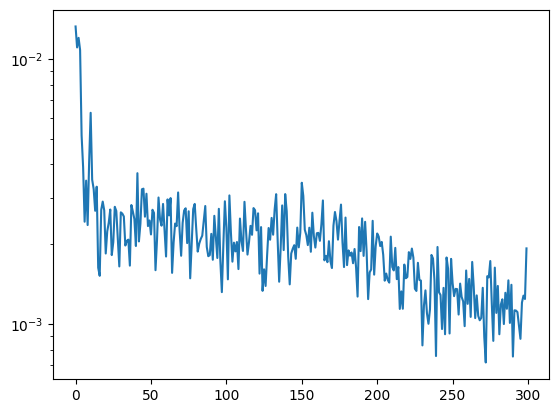

In [23]:
plt.plot(losses)
# set y_axis to log scale
plt.yscale('log')

In [24]:
max_episode_reward, qnet_loss_lifespan

(5.0, 23809)

In [11]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [25]:
# Save the model
model.to('cpu')
torch.save(model.state_dict(), "model.pt")

In [26]:
replay_buffer = fill_replay_buffer([], 1000)

In [33]:
# Create a DQN Agent
model, optimizer = declare_model_and_optimier()
model.to(model.device)

# Use MSE as the loss function
criterion = nn.MSELoss()
buffer_size = 10000
num_epochs = 10000
epochs_before_new_qloss = 1000
num_action_in_a_row = 4
num_stack_frames=4
minibatch_size = 32

# Pepare the environment
env = gym.make("ALE/Breakout-v5", frameskip=1)
env = gym.wrappers.AtariPreprocessing(env, grayscale_obs=False)
env = gym.wrappers.FrameStack(env, num_stack=num_stack_frames)
s_t = preprocess_image_stack(env.reset()[0])

losses = []
rewards = []
max_episode_reward = 0

loss_per_episode = []
reward_per_episode = 0

qnet_loss, _ = declare_model_and_optimier(model_state_dict=model.state_dict())
qnet_loss.to(model.device)
done = False

for epoch in range(num_epochs):

    # Reduce linearly epsilon with regards to number of epochs
    epsilon = max(1.0 - (epoch / num_epochs), 0.1)

    # Get action from the model or random
    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = model.step(s_t)

    # Do action and get reward
    for _ in range(num_action_in_a_row):
        s_t1, reward, done, _, info = env.step(action)
        reward_per_episode += reward
        if done: break
    
    if done:
        print("Max reward for this episode: ", reward_per_episode)

        env.reset()
        s_t = preprocess_image_stack(env.reset()[0])
        max_episode_reward = max(max_episode_reward, reward_per_episode)
        rewards.append(reward_per_episode)
        losses.append(np.mean(loss_per_episode))
        loss_per_episode = []
        reward_per_episode = 0
        done = False
        continue

    # Preprocess the next frame
    s_t1 = preprocess_image_stack(s_t1)

    # Update replay buffer
    if len(replay_buffer) > buffer_size:
        replay_buffer = replay_buffer[(int((1/10) * buffer_size)) + int(minibatch_size * ((1/10) * buffer_size)) % minibatch_size:]
    replay_buffer.append((
        torch.tensor(np.array(s_t.to('cpu'))[-1, :, :]),
        action,
        reward_per_episode,
        torch.tensor(np.array(s_t.to('cpu'))[-1, :, :]),
        done,
    ))

    # Current state is now the next state
    s_t = s_t1


    # Update the goal network
    if epoch % epochs_before_new_qloss == 0:
        qnet_loss, _ = declare_model_and_optimier(model_state_dict=model.state_dict())
        qnet_loss.to(model.device)
        print("New QNet Loss")

    # Sample random minibatch of transitions from D
    idx = random.randint(0, len(replay_buffer) - minibatch_size)
    minibatch = replay_buffer[idx: idx+minibatch_size]

    # Unpack the transitions in minibatch
    loss_s_t, loss_action, loss_reward, loss_s_t1, loss_done = zip(*minibatch)

    # Convert to tensors the minibatch
    loss_s_t = torch.stack(loss_s_t).float().to(model.device)
    loss_action = torch.tensor(loss_action).long().to(model.device)
    loss_reward = torch.tensor(loss_reward).float().to(model.device)
    loss_s_t1 = torch.stack(loss_s_t1).float().to(model.device)
    loss_done = torch.tensor(loss_done).float().to(model.device)

    # Compute each outputs for minibatch
    outputs = torch.max(model(loss_s_t), dim=1).values.to(model.device)

    # Compute labels for each outputs
    Y_j = 0.99 * torch.max(qnet_loss(loss_s_t1), dim=1).values * loss_done + loss_reward
    y_j = torch.nn.functional.normalize(y_j, dim=0)
    y_j = y_j.float().to(model.device)

    # Backpropagate the loss
    loss = criterion(outputs, y_j)
    loss_per_episode.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("TOTAL EPOCH: {}, Loss: {}, Mean Reward: {}, Actions in batch: {}".format(epoch, loss.item(), loss_reward.mean().cpu().detach(), {k:v for k,v in zip(*np.unique(loss_action.to('cpu'), return_counts=True))}))


max_episode_reward

New QNet Loss
TOTAL EPOCH: 0, Loss: 0.021461859345436096, Mean Reward: 0.0625, Actions in batch: {0: 9, 1: 4, 2: 12, 3: 7}
Max reward for this episode:  3.0
TOTAL EPOCH: 100, Loss: 1.8312485750016094e-08, Mean Reward: 0.0, Actions in batch: {0: 6, 1: 6, 2: 14, 3: 6}
Max reward for this episode:  1.0
Max reward for this episode:  0.0
TOTAL EPOCH: 200, Loss: 1.2553149630889493e-08, Mean Reward: 0.5, Actions in batch: {0: 5, 1: 5, 2: 12, 3: 10}
Max reward for this episode:  3.0
Max reward for this episode:  0.0
TOTAL EPOCH: 300, Loss: 2.2378124242550257e-08, Mean Reward: 0.59375, Actions in batch: {0: 4, 1: 13, 2: 9, 3: 6}
Max reward for this episode:  1.0
TOTAL EPOCH: 400, Loss: 2.1318948384418945e-08, Mean Reward: 2.28125, Actions in batch: {0: 5, 1: 8, 2: 12, 3: 7}
Max reward for this episode:  2.0
Max reward for this episode:  0.0
TOTAL EPOCH: 500, Loss: 2.8747113134386382e-08, Mean Reward: 0.0, Actions in batch: {0: 11, 1: 8, 2: 7, 3: 6}
Max reward for this episode:  1.0
Max reward f

KeyboardInterrupt: 

In [ ]:
# Save the model
model.to('cpu')
torch.save(model.state_dict(), "model.pt")

In [ ]:
plt.plot(losses)

In [ ]:
plt.plot(rewards)